In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import pandas as pd
import cv2
import matplotlib.image as mpimg
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LayerNormalization, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import LSTM

## Data Processing

In [4]:
folder_link = ""

In [7]:
train_data = []
train_output_arr = []
for coin in ["ada", "btc", "doge", "dot", "eth", "luna", "matic", "shib", "sol", "xrp"]:
    train_data.append(np.memmap(f"{folder_link}image_data/{coin}usdt/training_data.dat", dtype = np.uint8, mode = 'r').reshape((-1, 54, 72)))
    train_data.append(np.memmap(f"{folder_link}image_data/{coin}usdt/validation_data.dat", dtype = np.uint8, mode = 'r').reshape((-1, 54, 72)))
    train_output_arr.append(pd.read_csv(f"{folder_link}image_data/{coin}usdt/training_output.csv"))
    train_output_arr.append(pd.read_csv(f"{folder_link}image_data/{coin}usdt/validation_output.csv"))

train_data = np.concatenate(train_data)
print(train_data.shape)

(280437, 54, 72)


(54, 72)


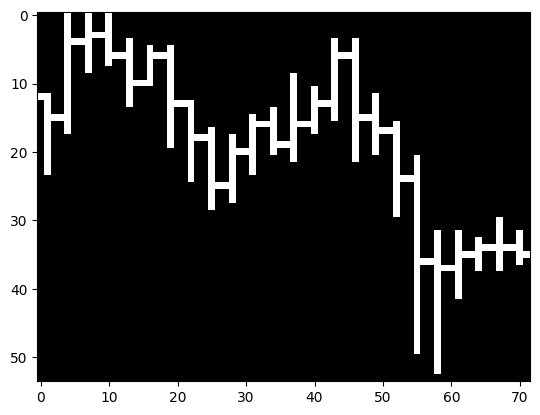

In [10]:
sample = train_data[0]
print(sample.shape)
plt.figure()
plt.imshow(sample, cmap="gray")

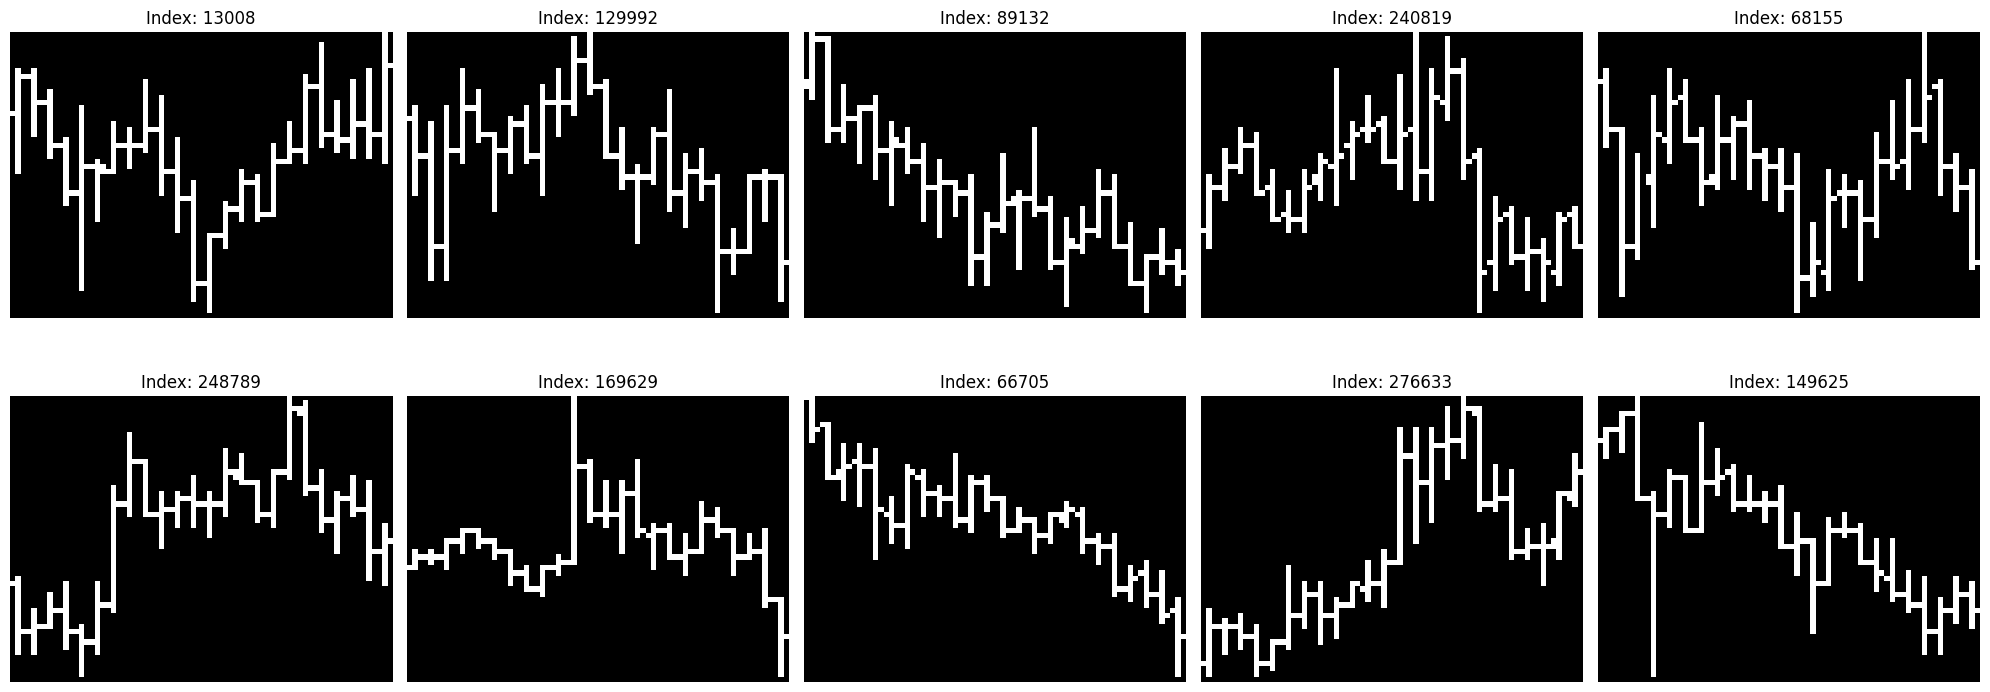

In [11]:
# Plot 10 random images and print their indices
fig, axs = plt.subplots(2, 5, figsize = (20, 8))
for i in range(10):
    index = np.random.randint(0, train_data.shape[0])
    axs[i // 5, i % 5].imshow(train_data[index], cmap = "gray")
    axs[i // 5, i % 5].set_title(f"Index: {index}")
    axs[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
def normalize(df):
    df["RollingMaxLR"] = df["LogReturns"].rolling(window = 24).apply(lambda x: np.max(x) - np.min(x))
    df["RollingMaxLR"] = df["RollingMaxLR"].fillna(df.loc[23, "RollingMaxLR"])
    df["NormalizedLogReturns"] = df["LogReturns"] / df["RollingMaxLR"]

for i in range(len(train_output_arr)):
    normalize(train_output_arr[i])

In [ ]:
train_output = pd.concat(train_output_arr)
train_output

In [ ]:
test_data = []
test_output_arr = []
for coin in ["ada", "btc", "doge", "dot", "eth", "luna", "matic", "shib", "sol", "xrp"] + ["bonk", "floki", "pepe", "wif"]:
    test_data.append(np.memmap(f"{folder_link}/image_data/{coin}usdt/testing_data.dat", dtype = np.uint8, mode = 'r').reshape((-1, 54, 72)))
    test_output_arr.append(pd.read_csv(f"{folder_link}/image_data/{coin}usdt/testing_output.csv"))

test_data = np.concatenate(test_data)
print(test_data.shape)

In [ ]:
for i in range(len(test_output_arr)):
    normalize(test_output_arr[i])

test_output = pd.concat(test_output_arr)
test_output

In [ ]:
test_output['NormalizedLogReturns'].plot(kind='hist', bins=20, title='NormalizedLogReturns')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Model

In [17]:
model = Sequential([
    # Layer 1
    Conv2D(32, kernel_size=(5, 3), padding='same', activation=None, input_shape=(54, 72, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(3, 1)),
    Dropout(0.25),

    # Layer 2
    Conv2D(64, kernel_size=(5, 3), padding='same', activation=None),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(3, 1)),
    Dropout(0.25),

    # Layer 3
    Conv2D(128, kernel_size=(5, 3), padding='same', activation=None),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(3, 1)),
    Dropout(0.25),

    # Fully connected layer
    Flatten(),
    Dense(256),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 54, 72, 32)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 54, 72, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 54, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 18, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 18, 72, 64)          │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 18, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 18, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 72, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 72, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 72, 128)          │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 72, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 6, 72, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 72, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 72, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          18,433 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 173,633 (678.25 KB)

 Trainable params: 173,185 (676.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
X.shape

(280437, 54, 72, 1)

In [20]:
y.shape

(258847,)

In [18]:
X = train_data.reshape((-1, 54, 72, 1))
y = train_output["NormalizedLogReturns"].values
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(X, y, epochs=10, validation_split=0.2, callbacks=[early_stopping])

model.save("model.h5")
model = tf.keras.models.load_model("model.h5")

Epoch 1/10
7011/7011 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2816

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 56088
'y' sizes: 34498


In [ ]:
# Make predictions
X_train = train_data.reshape((-1, 54, 72, 1))
y_pred = model.predict(X_train).flatten()

# Calculate the loss
loss = np.mean((y_pred - train_output["NormalizedLogReturns"].values) ** 2)
print(f"Loss: {loss}")

# Compare loss against benchmark
benchmark_loss = np.mean((train_output["NormalizedLogReturns"].values) ** 2)
print(f"Benchmark Loss: {benchmark_loss}")

8089/8089 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
Loss: 0.05642794656857429
Benchmark Loss: 0.05628091904922915


In [ ]:
X_test = test_data.reshape((-1, 54, 72, 1))
y_pred = model.predict(X_test).flatten()

# Calculate the loss
loss = np.mean((y_pred - test_output["NormalizedLogReturns"].values) ** 2)
print(f"Loss: {loss}")

# Compare loss against benchmark
benchmark_loss = np.mean((test_output["NormalizedLogReturns"].values) ** 2)
print(f"Benchmark Loss: {benchmark_loss}")